<a href="https://colab.research.google.com/github/nguyendat1811884/Data-Science-From-Theory-To-Practice/blob/main/Melbourne_Housing_Market/Melbourne_Housing_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import library**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.graph_objects as gp

from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
pd.set_option('precision', 4)

## **Funtion define**

In [3]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [4]:
def Zscore_Outliers(s, steps):
  """
  param:
        s: series of feature
        steps: 1, 2 or 3
  """
  m = s.mean()
  sd = s.std()
  upper_whisker = m + steps*sd
  lower_whisker = m - steps*sd
  return [False if (val > lower_whisker and val < upper_whisker) else True for val in s]

In [5]:
def IQR_Outliers(s):
  q1 = s.quantile(0.25)
  q3 = s.quantile(0.75)
  iqr = q3 - q1
  lower_tail = q1 - 1.5 * iqr
  upper_tail = q3 + 1.5 * iqr
  return [False if (val > lower_tail and val < upper_tail) else True for val in s]

In [6]:
def Iso_outliers(df):
    iso = IsolationForest( behaviour = 'new', random_state = 1, contamination= 'auto')
    preds = iso.fit_predict(df.values.reshape(-1,1))
    data = pd.DataFrame()
    data['cluster'] = preds
    print(data['cluster'].value_counts().sort_values(ascending=False))
    return data

In [7]:
# !gdown --id 11jJHP2ibxuzLPSpCD9UW-oWilasQeGCN

In [8]:
def mode_imputed(df, cols):
  for col in cols:
    df[col] = df[col].fillna(df[col].mode()[0])
  return df

In [9]:
def mean_imputed(df, cols):
  for col in cols:
    df[col] = df[col].fillna(df[col].mean())
  return df

In [10]:
def plot_missing(df):
  labels = list(df)
  missing = df.isnull().sum()
  non_missing = df.notnull().sum()

  fig, axes = plt.subplots()
  plt.bar(labels, non_missing, 0.9, label='Non Missing')
  plt.bar(labels, missing, 0.9, bottom=non_missing, label='Missing')
  plt.xlabel('Features')
  plt.ylabel('Amount')
  plt.setp(axes.get_xticklabels(), rotation=40, horizontalalignment='right')
  plt.legend()
  plt.tight_layout()
  plt.show()

In [11]:
def duplicateRows(df):
  # Check if contain duplicate rows
  duplicateRows = df[df.duplicated()]
  if not duplicateRows.empty:
    return duplicateRows
    print(duplicateRows.shape)
  else:
    print('There are no duplicate rows')

In [12]:
def one_way_anova(df1, col):
  result = df1.groupby(col)['Price'].apply(list)
  anova = f_oneway(*result)
  return anova

In [13]:
def hypothesis_testing(df, target, col_list):
  impact_list = []
  for col in col_list:
    col_name = col
    if 'bins' in col:
        col_name = col[:len(col) - 5]
    if col_name == target: continue
    print('* ', col_name)
    result = df.groupby(col)[target].apply(list)
    anova = f_oneway(*result)
    print(anova)
    if anova.pvalue < 0.05:
        impact_list.append(col_name)
        print('Bác bỏ H0')
    else:
        print('Chấp nhận H0 với xác suất có ý nghĩa {0}%'.format((1 - anova.pvalue)*100))
    print('--------------------------------------------------')
  return impact_list

## **Dowload and read data**

In [14]:
!gdown --id 1I57t_JKvxYDfCBVh-QmKCGxaEWkmNnBG
df = pd.read_csv('/content/Melbourne_housing_FULL.csv')

Downloading...
From: https://drive.google.com/uc?id=1I57t_JKvxYDfCBVh-QmKCGxaEWkmNnBG
To: /content/Melbourne_housing_FULL.csv
5.02MB [00:00, 9.75MB/s]


In [15]:
# df = pd.read_csv('/content/MELBOURNE_HOUSE_PRICES_LESS.csv')

In [16]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [17]:
df.shape

(34857, 21)

* Data has 34857 data points (rows) and 21 features (columns)

## **Improve Feature**

According to the dataset's description, both the columns 'Rooms' and 'Bedroom2' contain information about the number of bedrooms for each house but were gathered from different sources. We will consider whether data from these 2 columns are duplicated or related or not

In [18]:
cond = (df['Bedroom2'].notnull()) & (df['Rooms'] != df['Bedroom2'])
print('Num of difference rows: ', df[cond].shape[0])
print('Rate of difference: {0}%'.format(df[cond].shape[0] * 100 / df['Bedroom2'].notnull().sum()))

Num of difference rows:  948
Rate of difference: 3.5585585585585586%


In [19]:
abs(df[df['Rooms'] != df['Bedroom2']]['Rooms'] - df[df['Rooms'] != df['Bedroom2']]['Bedroom2']).sum()

1169.0

* We see that the difference between the two columns is not significant so we can remove 1 of the two columns. Besides, due to the amount of non-null values of 'Rooms' is 0 so that we will remove 'Bedroom2'

In [20]:
df.drop(['Bedroom2'], axis=1, inplace=True)

Instead of using 'YearBuilt' as a feature, we will transform it to 'Age'. The use of 'Age' instead of 'YearBuilt' will make more sense to indicate how many years since the house was built

In [21]:
df['Age'] = 2021 - df['YearBuilt']

Now, drop column 'YearBuilt'

In [22]:
df.drop(['YearBuilt'], axis=1, inplace=True)

Convert to Datetime Format

In [23]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

In [24]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [25]:
df = df.drop(['Date'], axis = 1)

## **Check and handle missing value**

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Distance       34856 non-null  float64
 8   Postcode       34856 non-null  float64
 9   Bathroom       26631 non-null  float64
 10  Car            26129 non-null  float64
 11  Landsize       23047 non-null  float64
 12  BuildingArea   13742 non-null  float64
 13  CouncilArea    34854 non-null  object 
 14  Lattitude      26881 non-null  float64
 15  Longtitude     26881 non-null  float64
 16  Regionname     34854 non-null  object 
 17  Propertycount  34854 non-null  float64
 18  Age   

* There are 9 columns that have data type float, 3 of data type int, and 7 of data type object
* There are a few columns that have less than 34875 non-null values => missing data

In [27]:
df_missing = missing_data(df)
df_missing 

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Age,Month,Year
Total,0,0,0,0,7610,0,0,1,1,8226,8728,11810,21115,3,7976,7976,3,3,19306,0,0
Percent,0,0,0,0,21.83,0,0,0.002869,0.002869,23.6,25.04,33.88,60.58,0.008607,22.88,22.88,0.008607,0.008607,55.39,0,0
Types,object,object,int64,object,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,object,float64,float64,int64,int64


First, we drop all rows with missing price (target)

In [28]:
df.dropna(subset=['Price'], inplace=True)

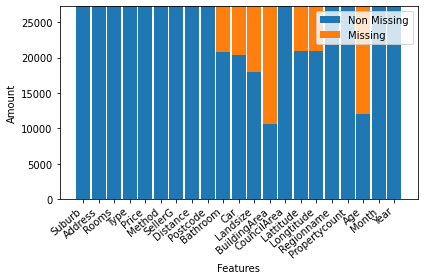

In [29]:
plot_missing(df)

* As we can see, quite a lot of data is missing, some more than 50%.

Now, let's handle them

1.   First, the simplest way to handle missing values is dropping columns or rows that have missing values. </b>
     However, in the case of this data, we should not use this method as a significant amount of data will be lost. 

2. So, we can using better way: imputation


* We will impute 'Car' and 'Bathroom' with mode

In [30]:
mode_imputed_features = ['Bathroom', 'Car', 'Postcode', 'Regionname', 'CouncilArea']
df = mode_imputed(df, mode_imputed_features)

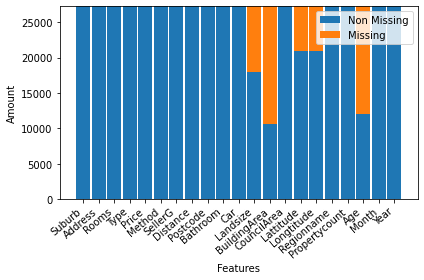

In [31]:
plot_missing(df)

* The remain, we will impute with mean value

In [32]:
mean_imputed_features = ['Landsize', 'BuildingArea', 'Lattitude', 'Longtitude', 'Age', 'Distance', 'Propertycount']
df = mean_imputed(df, mean_imputed_features)

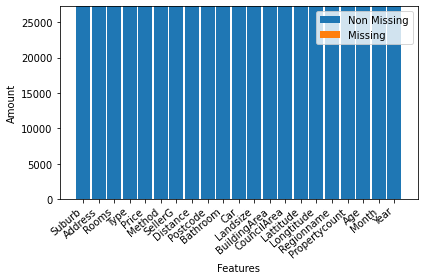

In [33]:
plot_missing(df)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27247 entries, 1 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27247 non-null  object 
 1   Address        27247 non-null  object 
 2   Rooms          27247 non-null  int64  
 3   Type           27247 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         27247 non-null  object 
 6   SellerG        27247 non-null  object 
 7   Distance       27247 non-null  float64
 8   Postcode       27247 non-null  float64
 9   Bathroom       27247 non-null  float64
 10  Car            27247 non-null  float64
 11  Landsize       27247 non-null  float64
 12  BuildingArea   27247 non-null  float64
 13  CouncilArea    27247 non-null  object 
 14  Lattitude      27247 non-null  float64
 15  Longtitude     27247 non-null  float64
 16  Regionname     27247 non-null  object 
 17  Propertycount  27247 non-null  float64
 18  Age   

In [35]:
duplicateRows(df)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Age,Month,Year
2260,Brunswick,8/2 Pottery Ct,3,t,641000.0,SP,RW,5.2,3056.0,2.0,1.0,0.0000,112.0000,Moreland City Council,-37.7703,144.9533,Northern Metropolitan,11918.0,121.0000,5,2016
2690,Camberwell,3/220 Warrigal Rd,2,u,435000.0,SP,LITTLE,7.8,3124.0,1.0,1.0,896.0000,77.0000,Boroondara City Council,-37.8479,145.0958,Southern Metropolitan,8920.0,61.0000,11,2016
5833,Kensington,106/80 Speakmen St,1,u,312000.0,SP,Edward,4.2,3031.0,1.0,2.0,593.4889,156.8346,Melbourne City Council,-37.8070,144.9967,Northern Metropolitan,5263.0,54.3908,8,2016
6127,Kew East,36 Belford Rd,4,h,1315000.0,SP,Nelson,7.5,3102.0,2.0,2.0,458.0000,200.0000,Boroondara City Council,-37.7981,145.0472,Southern Metropolitan,2671.0,91.0000,9,2016
7661,Pascoe Vale,2 Hazel Gr,2,h,915000.0,S,New,9.9,3044.0,1.0,3.0,629.0000,156.8346,Moreland City Council,-37.7312,144.9399,Northern Metropolitan,7485.0,46.0000,12,2016
8492,Reservoir,2/102 Rathcown Rd,2,u,440000.0,SP,Ray,11.2,3073.0,1.0,2.0,132.0000,83.0000,Darebin City Council,-37.7090,145.0219,Northern Metropolitan,21650.0,41.0000,10,2016
14110,Kensington,33 McCracken St,4,h,1817000.0,SP,Hodges,4.2,3031.0,2.0,1.0,309.0000,156.8346,Melbourne City Council,-37.7910,144.9280,Northern Metropolitan,5263.0,54.3908,4,2017
15799,Moonee Ponds,36 Aberfeldie St,3,h,1850000.0,SP,McDonald,6.2,3039.0,2.0,2.0,596.0000,203.0000,Moonee Valley City Council,-37.7609,144.9050,Western Metropolitan,6232.0,71.0000,6,2017
16460,Oak Park,79 New Rd,4,h,1071888.0,SP,Rendina,11.2,3046.0,2.0,4.0,553.0000,190.0000,Moreland City Council,-37.7133,144.9058,Northern Metropolitan,2651.0,20.0000,6,2017
16476,Parkdale,22 Keith St,4,h,1300000.0,SP,Buxton,21.5,3195.0,2.0,2.0,597.0000,150.0000,Kingston City Council,-37.9923,145.0847,South-Eastern Metropolitan,5087.0,51.0000,6,2017


In [36]:
df = df.drop_duplicates()
df.shape

(27227, 21)

## **Descriptive Statistics**

**<h5> Categorical data <h5>**

In [37]:
df.describe(percentiles=[.01, .25, .5, .75, .99], include='object')

,Suburb,Address,Type,Method,SellerG,CouncilArea,Regionname
count,27227,27227,27227,27227,27227,27227,27227
unique,345,26751,3,5,349,33,8
top,Reservoir,5 Charles St,h,S,Nelson,Boroondara City Council,Southern Metropolitan
freq,726,4,18462,17511,2731,2520,8522


* Observing the unique values, we notice that, for the Address column, the unique value is very high, almost equal to count, so the Address column cannot be used as a feature to building the model. => drop Address column
* The remaining columns can be used as features to build the model

In [38]:
# drop Address column
df.drop(['Address'], axis=1, inplace=True)
df.describe(percentiles=[.01, .25, .5, .75, .99], include='object')

,Suburb,Type,Method,SellerG,CouncilArea,Regionname
count,27227,27227,27227,27227,27227,27227
unique,345,3,5,349,33,8
top,Reservoir,h,S,Nelson,Boroondara City Council,Southern Metropolitan
freq,726,18462,17511,2731,2520,8522


In [39]:
duplicateRows(df).shape

(12, 20)

In [40]:
df = df.drop_duplicates()
df.shape

(27215, 20)

**<h5> Numeric data <h5>**

In [41]:
df.describe(percentiles=[.01, .1, .25, .5, .75, .95, .99])

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Age,Month,Year
count,27215.0000,2.7215e+04,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000,27215.0000
mean,2.9927,1.0502e+06,11.2838,3113.8169,1.4519,1.7867,593.5848,156.8448,-37.8070,144.9967,7566.6174,54.3867,7.1547,2016.8394
std,0.9548,6.4153e+05,6.7886,111.1837,0.6622,0.8697,3054.0868,281.0852,0.0804,0.1060,4492.5168,24.4832,3.1540,0.6362
min,1.0000,8.5000e+04,0.0000,3000.0000,0.0000,0.0000,0.0000,0.0000,-38.1904,144.4238,83.0000,2.0000,1.0000,2016.0000
1%,1.0000,3.1000e+05,1.6000,3006.0000,1.0000,0.0000,0.0000,40.1400,-38.0530,144.6621,852.0000,6.0000,1.0000,2016.0000
10%,2.0000,4.8600e+05,4.0000,3023.0000,1.0000,1.0000,130.4000,101.0000,-37.9059,144.8786,2671.0000,21.0000,3.0000,2016.0000
25%,2.0000,6.3500e+05,6.4000,3046.0000,1.0000,1.0000,351.0000,156.0000,-37.8429,144.9543,4294.0000,54.3908,5.0000,2016.0000
50%,3.0000,8.7000e+05,10.5000,3088.0000,1.0000,2.0000,593.4889,156.8346,-37.8070,144.9967,6567.0000,54.3908,7.0000,2017.0000
75%,4.0000,1.2950e+06,14.0000,3153.0000,2.0000,2.0000,593.4889,156.8346,-37.7660,145.0484,10412.0000,54.3908,10.0000,2017.0000
95%,5.0000,2.2500e+06,24.7000,3204.0000,3.0000,3.0000,864.0000,231.0000,-37.6846,145.1653,15510.0000,108.0000,12.0000,2018.0000


* Observe min values
> min of Landsize, BuildingArea = 0 -> outliers
* Observe and compare quartile value 99% and max value
> Quartile 99% of Rooms, Price, Bathroom, Car, Landsize, BuildingArea, Age is pretty much smaller than the max value => may contain outliers<br>
> Quartile 99% of Age is pretty much smaller than the max value => may contain outliers





## **Outliers**

In [42]:
df.shape

(27215, 20)

In [43]:
df[df['Landsize'] == 0].shape

(1940, 20)

In [44]:
df = df[df['Landsize'] != 0]
df.shape

(25275, 20)

In [45]:
df[df['BuildingArea'] == 0].shape

(61, 20)

In [46]:
df = df[df['BuildingArea'] != 0]
df.shape

(25214, 20)

In [47]:
df[df['Bathroom'] == 0].shape

(16, 20)

In [48]:
df = df[df['Bathroom'] != 0]
df.shape

(25198, 20)

In [49]:
df[df['Age'] >= 200].shape

(2, 20)

In [50]:
df = df[df['Age'] < 200]
df.shape

(25196, 20)

**Price**

In [51]:
isOutlier = Zscore_Outliers(df['Bathroom'], 3)
df[isOutlier].shape

(236, 20)

In [52]:
isnotOutlier = [not x for x in isOutlier]
df = df[isnotOutlier]
df.shape

(24960, 20)

**Rooms**

In [53]:
isOutlier = Zscore_Outliers(df['Rooms'], 4)
df[isOutlier].shape

(30, 20)

In [54]:
df.shape

(24960, 20)

In [55]:
isnotOutlier = [not x for x in isOutlier]
df = df[isnotOutlier]
df.shape

(24930, 20)

**Bathroom**

In [56]:
isOutlier = Zscore_Outliers(df['Bathroom'], 4)
df[isOutlier].shape

(0, 20)

In [57]:
isnotOutlier = [not x for x in isOutlier]
df = df[isnotOutlier]
df.shape

(24930, 20)

**Car**

In [58]:
isOutlier = Zscore_Outliers(df['Car'], 5)
df[isOutlier].shape

(38, 20)

In [59]:
isnotOutlier = [not x for x in isOutlier]
df = df[isnotOutlier]
df.shape

(24892, 20)

**Landsize**

In [60]:
isOutlier = Zscore_Outliers(df['Landsize'], 4)
df[isOutlier].shape

(31, 20)

In [61]:
isnotOutlier = [not x for x in isOutlier]
df = df[isnotOutlier]
df.shape

(24861, 20)

**BuildingArea**

In [62]:
isOutlier = Zscore_Outliers(df['BuildingArea'], 4)
df[isOutlier].shape

(82, 20)

In [63]:
isnotOutlier = [not x for x in isOutlier]
df = df[isnotOutlier]
df.shape

(24779, 20)

## **Exploratory Data Analysis (EDA)**

**Price**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.



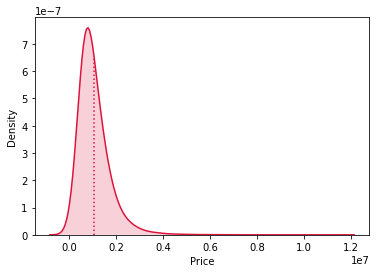

In [64]:
ax = sns.kdeplot(df['Price'], bw=0.5, shade=False, color='crimson')
kdeline = ax.lines[0]
mean = df['Price'].mean()
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean, xs, ys)
ax.vlines(mean, 0, height, color='crimson', ls=':')
ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)

* Most houses are priced at <= 6M



In [65]:
# df1 = Iso_outliers(df['Price'])
# df1.shape

In [66]:
# df['cluster'] = list(df1['cluster'])
# df = df[df['cluster'] == 1]
# df.shape

In [67]:
# df = df.drop(['cluster'], axis = 1)
# df.shape

-------------------------------------------------------

In [68]:
df.select_dtypes('object').columns

Index(['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname'], dtype='object')

**<h5> Price by Type <h5>**

In [69]:
type_count = df['Type'].value_counts().to_frame()
type_count

,Type
h,17838
u,4239
t,2702


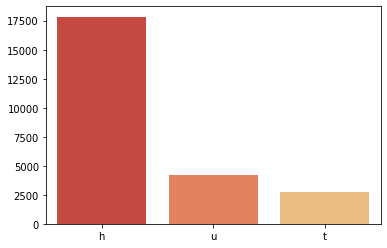

In [70]:
vals = type_count['Type'].values
labels = type_count.index.to_list()
colors = plt.cm.Dark2(range(len(labels)))
sns.set_palette(sns.color_palette("RdYlGn", 8))
sns.barplot(x=labels, y=vals)
plt.show()

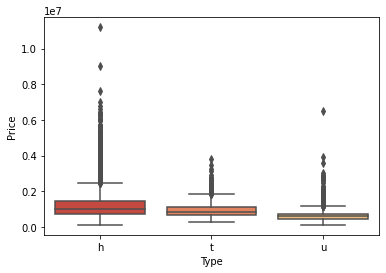

In [71]:
sns.boxplot(x='Type', y='Price', data=df)

* the average price of type **h** (villa) > **t** (townhouse) >> **u** (duplex)

**Price by Method**

In [72]:
type_count = df['Method'].value_counts().to_frame()
type_count

,Method
S,16132
SP,3217
PI,2919
VB,2339
SA,172


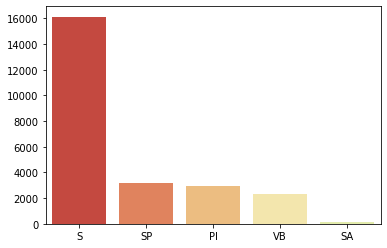

In [73]:
vals = type_count['Method'].values
labels = type_count.index.to_list()
colors = plt.cm.Dark2(range(len(labels)))
sns.set_palette(sns.color_palette("RdYlGn", 8))
sns.barplot(x=labels, y=vals)
plt.show()

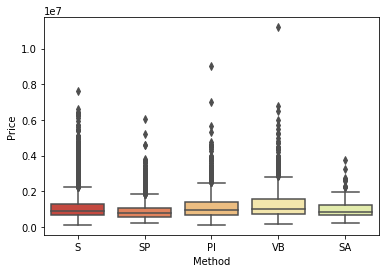

In [74]:
sns.boxplot(x='Method', y='Price', data=df)

* House prices by different selling methods are similar => may not affect the target

**Price by CouncilArea**

In [75]:
price_by_council = df[['Price', 'CouncilArea']].groupby(['CouncilArea']).mean().sort_values('Price', ascending=0)[:15]
price_by_council

,Price
CouncilArea,
Stonnington City Council,1.7413e+06
Boroondara City Council,1.6953e+06
Bayside City Council,1.5657e+06
Port Phillip City Council,1.2935e+06
Manningham City Council,1.2186e+06
Monash City Council,1.1863e+06
Glen Eira City Council,1.1688e+06
Whitehorse City Council,1.1641e+06
Yarra City Council,1.1641e+06


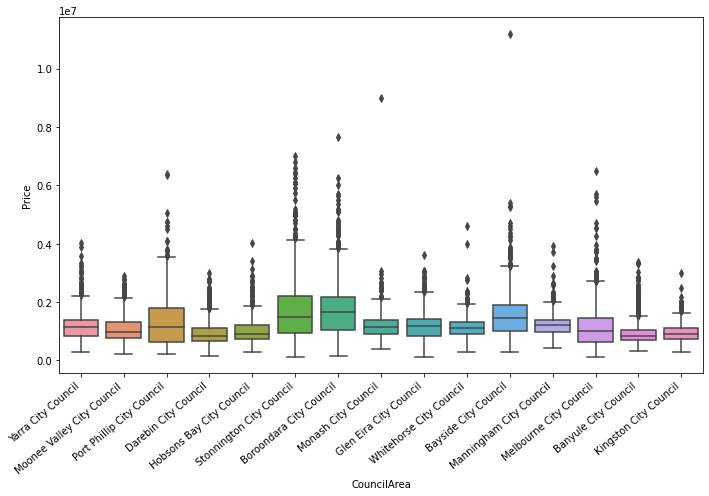

In [76]:
fig, ax = fig, ax = plt.subplots(figsize=(10,7))
ax = sns.boxplot(x='CouncilArea', y='Price', data=df[df['CouncilArea'].isin(price_by_council.index.tolist())])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

* Price distribution of different Council Areas is different

**Price by Regionname**

In [77]:
regionname_count = df['Regionname'].value_counts()
regionname_count

Southern Metropolitan         7269
Northern Metropolitan         7166
Western Metropolitan          5480
Eastern Metropolitan          3159
South-Eastern Metropolitan    1299
Northern Victoria              157
Eastern Victoria               154
Western Victoria                95
Name: Regionname, dtype: int64

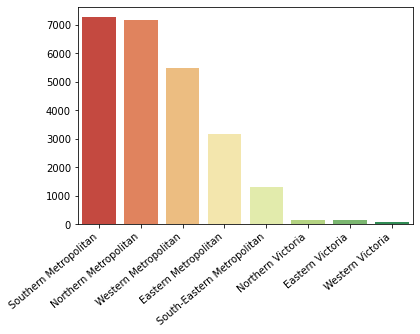

In [78]:
vals = regionname_count.values
labels = regionname_count.index.to_list()
colors = plt.cm.Dark2(range(len(labels)))
sns.set_palette(sns.color_palette("RdYlGn", 8))
ax = sns.barplot(x=labels, y=vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

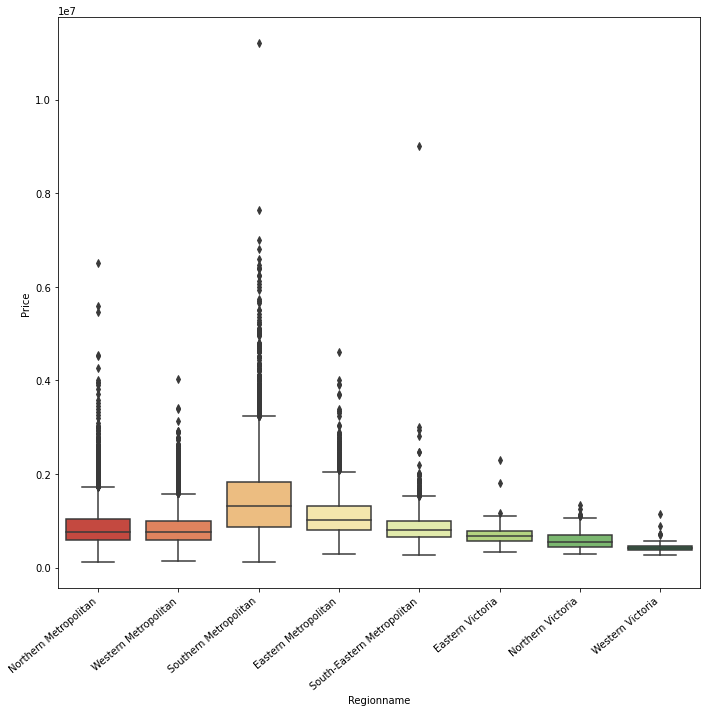

In [79]:
fig, ax = fig, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(x='Regionname', y='Price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

* Mean price of Northern and Western, Southern and Eastern is almost no difference
* Mean price of Metropolitan region is higher than Victoria region

In [80]:
df.select_dtypes(exclude='object').columns

Index(['Rooms', 'Price', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'Lattitude', 'Longtitude', 'Propertycount', 'Age',
       'Month', 'Year'],
      dtype='object')

**Price by Rooms**

In [81]:
room_count = df['Rooms'].value_counts()
room_count

3    11563
4     5719
2     5578
5     1066
1      744
6      109
Name: Rooms, dtype: int64

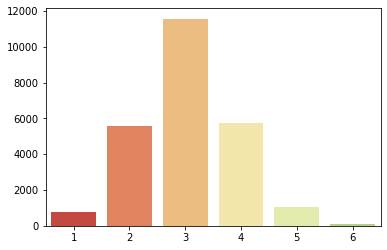

In [82]:
vals = room_count.values
labels = room_count.index.to_list()
colors = plt.cm.Dark2(range(len(labels)))
sns.set_palette(sns.color_palette("RdYlGn", 8))
ax = sns.barplot(x=labels, y=vals)
plt.show()

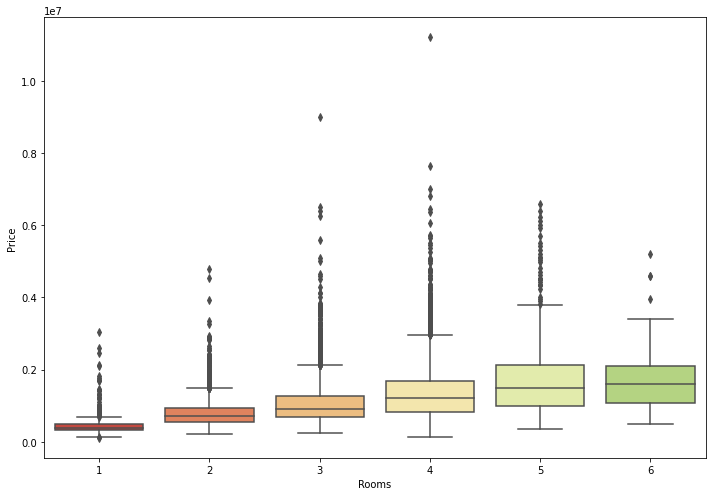

In [83]:
fig, ax = fig, ax = plt.subplots(figsize=(10,7))
ax = sns.boxplot(x='Rooms', y='Price', data=df)
plt.tight_layout()
plt.show()

In [84]:
# correlation 
df['Rooms'].corr(df['Price'])

0.4194017291191197

* Number of room and price are positively correlated. The more rooms, the more expensive the price

**Distance**

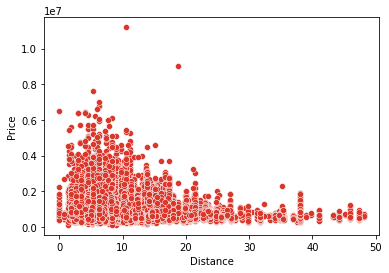

In [85]:
sns.scatterplot(x='Distance', y='Price', data=df)

In [86]:
# correlation 
df['Distance'].corr(df['Price'])

-0.265868238453228

* Number of room and price are negatively correlated. The closer to the downtown, the higher the price

**Bathroom**

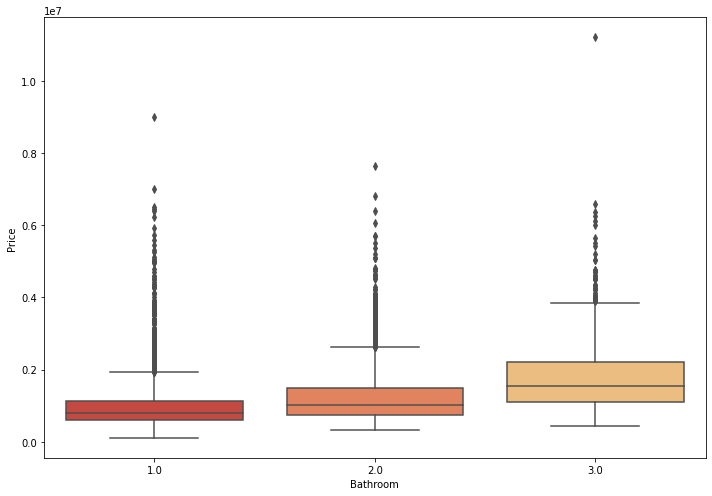

In [87]:
fig, ax = fig, ax = plt.subplots(figsize=(10,7))
ax = sns.boxplot(x='Bathroom', y='Price', data=df)
plt.tight_layout()
plt.show()

* Number of bathroom and price are positively correlated. The more bathroom, the more expensive the price

**Car**

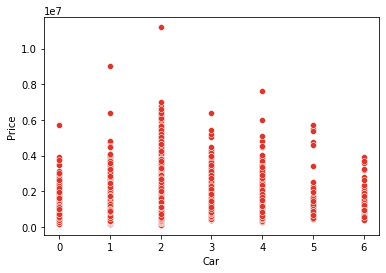

In [88]:
sns.scatterplot(x='Car', y='Price', data=df)

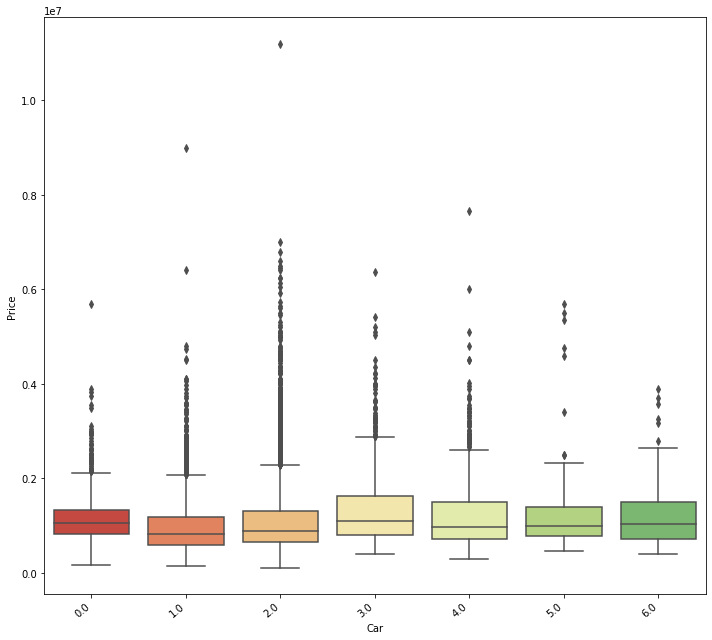

In [89]:
fig, ax = fig, ax = plt.subplots(figsize=(10,9))
ax = sns.boxplot(x='Car', y='Price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

* Prices of houses with 3  car spots or no car spots are higher than the rest. 
* Houses with 1 car spot have the lowest price 

**Price by Landsize**

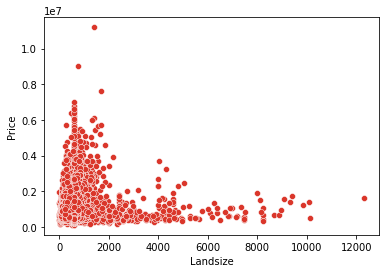

In [90]:
sns.scatterplot(x='Landsize', y='Price', data=df)

In [91]:
# correlation 
df['Landsize'].corr(df['Price'])

0.029602649618813044

**Price by BuildingArea**

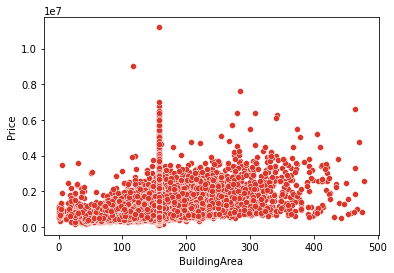

In [92]:
sns.scatterplot(x='BuildingArea', y='Price', data=df)

In [93]:
# correlation 
df['BuildingArea'].corr(df['Price'])

0.317922921666078

* Number of room and price are positively correlated. The lager building area, the more expensive the price

**Price by Month**

In [94]:
month_count = df['Month'].value_counts()
month_count

11    3137
9     2966
10    2935
5     2295
3     2201
6     2131
8     2081
7     2063
2     1968
12    1349
4     1017
1      636
Name: Month, dtype: int64

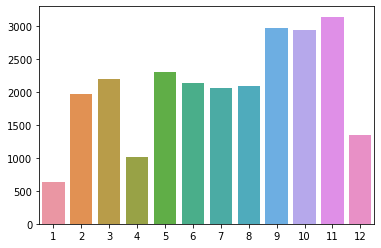

In [95]:
vals = month_count.values
labels = month_count.index.to_list()
colors = plt.cm.Dark2(range(len(labels)))
sns.set_palette(sns.color_palette("RdYlGn", 8))
ax = sns.barplot(x=labels, y=vals)
plt.show()

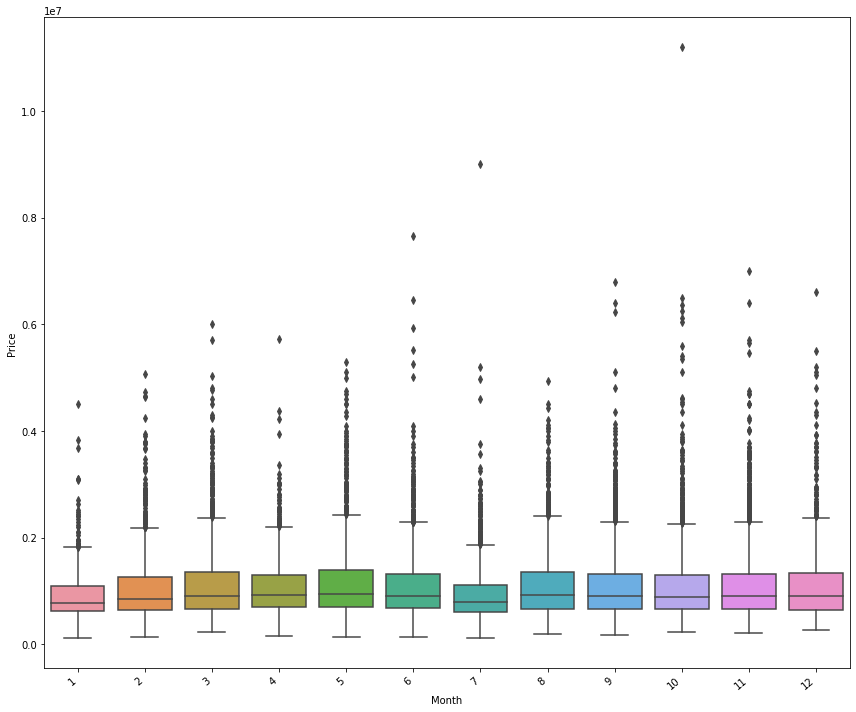

In [96]:
fig, ax = fig, ax = plt.subplots(figsize=(12,10))
ax = sns.boxplot(x='Month', y='Price', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

* The mean price of houses in January and July is lower than the rest.
* The mean price of the rest is not much different 

**Age**

In [97]:
df1 = df[['Price', 'Age']].copy()

In [98]:
lst = df1['Age'].tolist()
lst = [1 if x > 100 else 0 for x in lst]
df1['Historic'] = lst

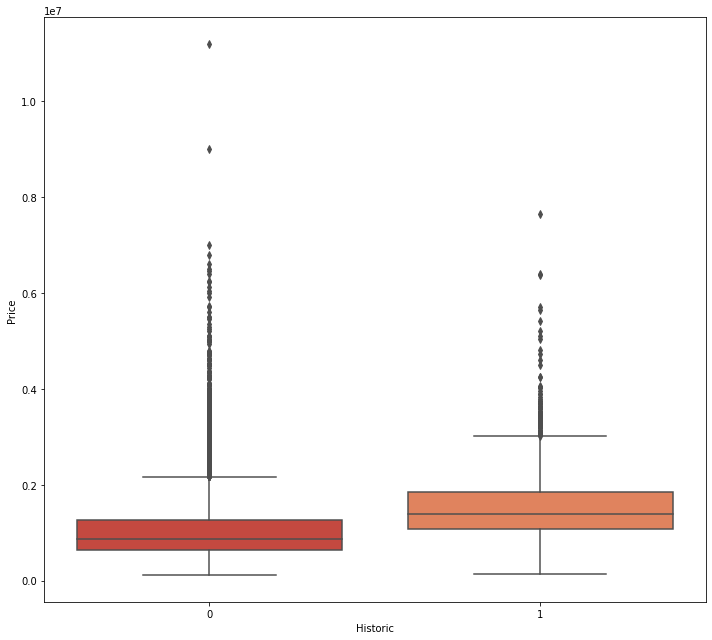

In [99]:
fig, ax = fig, ax = plt.subplots(figsize=(10,9))
ax = sns.boxplot(x='Historic', y='Price', data=df1)
plt.tight_layout()
plt.show()

* The older the houses, the higher the price

In [100]:
df.describe(percentiles=[.01, .1, .25, .5, .75, .95, .99])

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Age,Month,Year
count,24779.0000,2.4779e+04,24779.0000,24779.0000,24779.0000,24779.000,24779.0000,24779.0000,24779.0000,24779.0000,24779.0000,24779.0000,24779.0000,24779.0000
mean,3.0449,1.0650e+06,11.6354,3113.7069,1.4382,1.819,576.3575,155.0520,-37.8054,144.9969,7510.7644,55.0737,7.1565,2016.8766
std,0.8864,6.1769e+05,6.7947,113.2980,0.6037,0.817,439.9907,40.9938,0.0816,0.1082,4517.2690,23.8326,3.1856,0.6320
min,1.0000,1.1200e+05,0.0000,3000.0000,1.0000,0.000,1.0000,1.0000,-38.1904,144.4238,121.0000,2.0000,1.0000,2016.0000
1%,1.0000,3.3000e+05,1.8000,3011.0000,1.0000,0.000,90.7800,54.0000,-38.0605,144.6595,852.0000,6.0000,1.0000,2016.0000
10%,2.0000,5.1000e+05,4.3000,3023.0000,1.0000,1.000,216.0000,110.0000,-37.9075,144.8758,2651.0000,21.0000,2.0000,2016.0000
25%,2.0000,6.5500e+05,6.9000,3046.0000,1.0000,1.000,452.0000,156.8346,-37.8394,144.9538,4217.0000,54.3908,5.0000,2016.0000
50%,3.0000,8.9600e+05,10.7000,3085.0000,1.0000,2.000,593.4889,156.8346,-37.8070,144.9967,6543.0000,54.3908,8.0000,2017.0000
75%,4.0000,1.3020e+06,14.3000,3152.0000,2.0000,2.000,602.0000,156.8346,-37.7632,145.0505,10331.0000,54.3908,10.0000,2017.0000
95%,4.0000,2.2100e+06,24.8000,3204.0000,3.0000,3.000,868.0000,224.0000,-37.6812,145.1683,15510.0000,111.0000,12.0000,2018.0000


In [101]:
df1 = df.copy()
df1['Rooms'] = pd.cut(x=df1['Rooms'], bins=3)
df1['Distance'] = pd.cut(x=df1['Distance'], bins=5)
df1['Car'] = pd.cut(x=df1['Car'], bins=5)
df1['Landsize'] = pd.cut(x=df1['Landsize'], bins=6)
df1['BuildingArea'] = pd.cut(x=df1['BuildingArea'], bins=5)
df1['Lattitude'] = pd.cut(x=df1['Lattitude'], bins=2)
df1['Longtitude'] = pd.cut(x=df1['Longtitude'], bins=2)
df1['Propertycount'] = pd.cut(x=df1['Propertycount'], bins=10)
df1['Age'] = pd.cut(x=df1['Age'], bins=4)

In [102]:
hypothesis_testing(df1, 'Price', df1.columns.tolist())

*  Suburb
F_onewayResult(statistic=44.284227178689996, pvalue=0.0)
Bác bỏ H0
--------------------------------------------------
*  Rooms
F_onewayResult(statistic=1786.9748871245436, pvalue=0.0)
Bác bỏ H0
--------------------------------------------------
*  Type
F_onewayResult(statistic=1549.8126605224713, pvalue=0.0)
Bác bỏ H0
--------------------------------------------------
*  Method
F_onewayResult(statistic=105.98448240281117, pvalue=1.1035900313017648e-89)
Bác bỏ H0
--------------------------------------------------
*  SellerG
F_onewayResult(statistic=27.18957471638886, pvalue=0.0)
Bác bỏ H0
--------------------------------------------------
*  Distance
F_onewayResult(statistic=441.6435849273239, pvalue=0.0)
Bác bỏ H0
--------------------------------------------------
*  Postcode
F_onewayResult(statistic=69.55454456292655, pvalue=0.0)
Bác bỏ H0
--------------------------------------------------
*  Bathroom
F_onewayResult(statistic=1647.6468693670017, pvalue=0.0)
Bác bỏ H0
-------

['Suburb',
 'Rooms',
 'Type',
 'Method',
 'SellerG',
 'Distance',
 'Postcode',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'CouncilArea',
 'Lattitude',
 'Longtitude',
 'Regionname',
 'Propertycount',
 'Age',
 'Month',
 'Year']

## **Linear regression**

In [103]:
df.columns.tolist()

['Suburb',
 'Rooms',
 'Type',
 'Price',
 'Method',
 'SellerG',
 'Distance',
 'Postcode',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'CouncilArea',
 'Lattitude',
 'Longtitude',
 'Regionname',
 'Propertycount',
 'Age',
 'Month',
 'Year']

In [104]:
features = ['Suburb','Rooms','Type','Method', 'Distance','Bathroom','Car','Landsize','BuildingArea','Lattitude','Longtitude',
            'Regionname','Propertycount','Age','Month','Year','Postcode', 'SellerG', 'CouncilArea']

In [105]:
X = df[features]
y = df['Price']

In [106]:
columns_to_encode = X.select_dtypes(include='object').columns.tolist()

In [107]:
for col in columns_to_encode:
  X[col] = X[col].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [108]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24779 entries, 1 to 34856
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         24779 non-null  category
 1   Rooms          24779 non-null  int64   
 2   Type           24779 non-null  category
 3   Method         24779 non-null  category
 4   Distance       24779 non-null  float64 
 5   Bathroom       24779 non-null  float64 
 6   Car            24779 non-null  float64 
 7   Landsize       24779 non-null  float64 
 8   BuildingArea   24779 non-null  float64 
 9   Lattitude      24779 non-null  float64 
 10  Longtitude     24779 non-null  float64 
 11  Regionname     24779 non-null  category
 12  Propertycount  24779 non-null  float64 
 13  Age            24779 non-null  float64 
 14  Month          24779 non-null  int64   
 15  Year           24779 non-null  int64   
 16  Postcode       24779 non-null  float64 
 17  SellerG        24779 non-null  

In [109]:
columns_to_scale = X.select_dtypes(exclude='category').columns.tolist()

In [110]:
scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
X.head()

,Suburb,Rooms,Type,Method,Distance,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Regionname,Propertycount,Age,Month,Year,Postcode,SellerG,CouncilArea
1,Abbotsford,-1.1788,h,S,-1.3445,-0.7259,-1.0025,-0.8508,0.0435,0.0714,1.3853e-02,Northern Metropolitan,-0.773,-0.0287,1.5205,-1.3870,-0.4123,Biggin,Yarra City Council
2,Abbotsford,-1.1788,h,S,-1.3445,-0.7259,-2.2264,-0.9554,-1.8552,-0.0303,-3.2339e-02,Northern Metropolitan,-0.773,2.7663,-1.6187,-1.3870,-0.4123,Biggin,Yarra City Council
4,Abbotsford,-0.0506,h,SP,-1.3445,0.9306,-2.2264,-1.0054,-0.1232,-0.0474,-2.3101e-02,Northern Metropolitan,-0.773,2.7663,-1.3048,0.1952,-0.4123,Biggin,Yarra City Council
5,Abbotsford,-0.0506,h,PI,-1.3445,0.9306,-1.0025,-1.0963,0.0435,0.1045,-4.3670e-06,Northern Metropolitan,-0.773,-0.0287,-1.3048,0.1952,-0.4123,Biggin,Yarra City Council
6,Abbotsford,1.0776,h,VB,-1.3445,-0.7259,0.2215,-1.0372,-0.3184,-0.0217,-2.5872e-02,Northern Metropolitan,-0.773,-2.0172,-0.3631,-1.3870,-0.4123,Nelson,Yarra City Council


In [112]:
X = pd.get_dummies(X)

In [113]:
X.head()

,Rooms,Distance,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Age,Month,Year,Postcode,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,Suburb_Ardeer,Suburb_Armadale,Suburb_Ascot Vale,Suburb_Ashburton,Suburb_Ashwood,Suburb_Aspendale,Suburb_Aspendale Gardens,Suburb_Attwood,Suburb_Avondale Heights,Suburb_Bacchus Marsh,Suburb_Balaclava,Suburb_Balwyn,Suburb_Balwyn North,Suburb_Bayswater,Suburb_Bayswater North,Suburb_Beaconsfield,Suburb_Beaconsfield Upper,...,SellerG_hockingstuart/Marshall,SellerG_hockingstuart/Sweeney,SellerG_hockingstuart/hockingstuart,SellerG_iHomes,SellerG_iProperty,SellerG_iSell,SellerG_iTRAK,CouncilArea_Banyule City Council,CouncilArea_Bayside City Council,CouncilArea_Boroondara City Council,CouncilArea_Brimbank City Council,CouncilArea_Cardinia Shire Council,CouncilArea_Casey City Council,CouncilArea_Darebin City Council,CouncilArea_Frankston City Council,CouncilArea_Glen Eira City Council,CouncilArea_Greater Dandenong City Council,CouncilArea_Hobsons Bay City Council,CouncilArea_Hume City Council,CouncilArea_Kingston City Council,CouncilArea_Knox City Council,CouncilArea_Macedon Ranges Shire Council,CouncilArea_Manningham City Council,CouncilArea_Maribyrnong City Council,CouncilArea_Maroondah City Council,CouncilArea_Melbourne City Council,CouncilArea_Melton City Council,CouncilArea_Mitchell Shire Council,CouncilArea_Monash City Council,CouncilArea_Moonee Valley City Council,CouncilArea_Moorabool Shire Council,CouncilArea_Moreland City Council,CouncilArea_Nillumbik Shire Council,CouncilArea_Port Phillip City Council,CouncilArea_Stonnington City Council,CouncilArea_Whitehorse City Council,CouncilArea_Whittlesea City Council,CouncilArea_Wyndham City Council,CouncilArea_Yarra City Council,CouncilArea_Yarra Ranges Shire Council
1,-1.1788,-1.3445,-0.7259,-1.0025,-0.8508,0.0435,0.0714,1.3853e-02,-0.773,-0.0287,1.5205,-1.3870,-0.4123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-1.1788,-1.3445,-0.7259,-2.2264,-0.9554,-1.8552,-0.0303,-3.2339e-02,-0.773,2.7663,-1.6187,-1.3870,-0.4123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,-0.0506,-1.3445,0.9306,-2.2264,-1.0054,-0.1232,-0.0474,-2.3101e-02,-0.773,2.7663,-1.3048,0.1952,-0.4123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,-0.0506,-1.3445,0.9306,-1.0025,-1.0963,0.0435,0.1045,-4.3670e-06,-0.773,-0.0287,-1.3048,0.1952,-0.4123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,1.0776,-1.3445,-0.7259,0.2215,-1.0372,-0.3184,-0.0217,-2.5872e-02,-0.773,-2.0172,-0.3631,-1.3870,-0.4123,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**Holdout**

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [115]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6961778495778645

In [116]:
reg.score(X_test, y_test)

-6.023561274350554e+16

In [117]:
predictions = reg.predict(X_test)

print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MSE: 2.2979026048962458e+28
RMSE: 151588344040570.8


In [118]:
coeff_df = pd.DataFrame(reg.coef_, X.columns,columns=['Coefficient'])
coeff_df = coeff_df.sort_values("Coefficient", ascending = False)
coeff_df

,Coefficient
CouncilArea_Maroondah City Council,1.2386e+16
CouncilArea_Darebin City Council,8.6505e+15
Suburb_Botanic Ridge,6.8237e+15
CouncilArea_Boroondara City Council,6.6743e+15
CouncilArea_Banyule City Council,6.4978e+15
...,...
Regionname_Southern Metropolitan,-1.1863e+16
Regionname_Eastern Metropolitan,-1.4691e+16
Type_h,-7.1110e+16
Type_t,-7.1110e+16


**Cross Validation**

In [119]:
scores = cross_val_score(reg, X, y, cv=10)
scores

array([-1.29661023e+15, -3.88760956e+18, -3.55245798e+15, -3.36654028e+16,
       -2.21185356e+19,  6.23696949e-01, -1.48429240e+17, -4.82653373e+16,
       -6.97261649e+18, -5.13058413e+17])

In [120]:
scores.mean()

-3.372702907061665e+18

## **PCA**

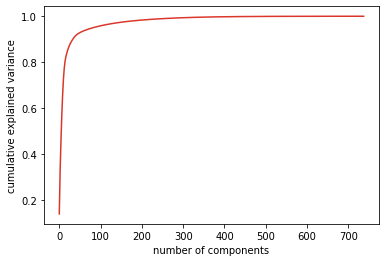

In [121]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [122]:
pca = PCA(n_components=500)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (24779, 738)
transformed shape: (24779, 500)


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)

In [124]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6929465011861373

In [125]:
reg.score(X_test, y_test)

0.6519068876880219

In [126]:
predictions = reg.predict(X_test)

print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MSE: 132792551299.2109
RMSE: 364407.1230083338


In [127]:
scores = cross_val_score(reg, X_pca, y, cv=10)
scores

array([0.66159189, 0.69092447, 0.6431291 , 0.67113968, 0.6679945 ,
       0.63077125, 0.69442742, 0.61385342, 0.66570417, 0.70838196])

In [128]:
scores.mean()

0.6647917853707433